# Deep Learning for Natural Language and Code: Exercise 1

In [4]:
import os
from sklearn.datasets import load_svmlight_file

In [5]:
TRAIN_DATA_PATH = os.path.join("..", 'datasets', "aclImdb", "train")
TEST_DATA_PATH = os.path.join("..", 'datasets', "aclImdb", "test")

# Task 1: LIBSVM - BOW

## Load data

1. Download the dataset from [here](https://ai.stanford.edu/%7Eamaas/data/sentiment)
1. Copy the dataset next to this Jupyter (.ipynb file)
1. Install:
    * Sklearn (This library is only allowed to use for reading the BOW in LIBSVM format)

In [6]:
def read_bow_libsvm(path_data, n_features=None):
    """ Function for reading the data in the LIBSVM format (.feat files). 
    
    Parameters
    ----------
    path_data: str
        path of the folder that contains the data that is going to be used. (should be test or train)
    n_features: int, optional
        The number of features to expect. If None, it's inferred from the data.
        
    Returns
    ---------
    X,y: scipy.sparse.csr_matrix, array_like
        Data arrays, X is a sparse matrix, y is an array of shape [#documents,] 
    """

    X, y = load_svmlight_file(path_data, n_features=n_features)

    # Removed X = X.todense() to keep X as a sparse matrix
    
    return X, y

In [7]:
def read_vocab(vocab_path = os.path.join(".","aclImdb", "imdb.vocab")):
    """ Function for reading the vocabulary (.vocab file). 
    
    Parameters
    ----------
    None
        
    Returns
    ---------
    vocab: list
        list with the values of y ...... 
    """
    
    
    with open(vocab_path, encoding='utf-8') as f:
        lines = f.read()

    lines = lines.split('\n')
    
    vocab = []
    for line in lines:
        vocab.append(line)
    
    return vocab

In [8]:
# Read the vocabulary
vocabulary = read_vocab(
    vocab_path=os.path.join('..', 'datasets', 'aclImdb', 'imdb.vocab')  # Adjust path as needed
)

# Read the the bag of words and the Y for the training data
X, y = read_bow_libsvm(path_data=os.path.join('..', 'datasets', 'aclImdb', 'train', 'labeledBow.feat'))

# Read the the bag of words and the Y for the test data
# Pass n_features from the training set to ensure consistent feature dimensions
X_test, y_test = read_bow_libsvm(path_data=os.path.join('..', 'datasets', 'aclImdb', 'test', 'labeledBow.feat'),
                                   n_features=X.shape[1])

## Understanding the LIBSVM-BOW
1. What are the values in y? 
1. Why do we use  todense() in the read_bow_libsvm function?
1. How could you know which word in the vocabulary corresponds to each index in the BOW?

In [9]:
# play with the previous loaded variables and understand the values of each one.
# Compare vocabulary sizes
import numpy as np
# Display a few words from the vocabulary and their indices
for i in range(10):
    print(f"Index {i}: {vocabulary[i]}")

# Check a specific document
doc_index = 0  # First document
print("\nDocument example:")
print(f"Document shape: {X[doc_index].shape}")

# Find non-zero features (words that appear in this document)
# For a sparse matrix, X[doc_index] is a sparse row. .nonzero()[1] gives column indices of non-zero elements.
non_zero_indices = X[doc_index].nonzero()[1]
print("\nWords that appear in this document:")
for idx in non_zero_indices[:10]:  # Show just first 10 words
    word = vocabulary[idx]
    count = X[doc_index, idx] # Accessing element in sparse matrix
    print(f"Word: '{word}', Index: {idx}, Count: {int(count)}")

Index 0: the
Index 1: and
Index 2: a
Index 3: of
Index 4: to
Index 5: is
Index 6: it
Index 7: in
Index 8: i
Index 9: this

Document example:
Document shape: (1, 89527)

Words that appear in this document:
Word: 'the', Index: 0, Count: 9
Word: 'and', Index: 1, Count: 1
Word: 'a', Index: 2, Count: 4
Word: 'of', Index: 3, Count: 4
Word: 'to', Index: 4, Count: 6
Word: 'is', Index: 5, Count: 4
Word: 'it', Index: 6, Count: 2
Word: 'in', Index: 7, Count: 2
Word: 'i', Index: 8, Count: 4
Word: 'that', Index: 10, Count: 4


# Task 2: Bag of Words (BOW)
## Load Raw text and scores 

1. Be sure to have downloaded the dataset from the link provided in the exercise and have read the README file
1. Be sure to have copied the dataset next to this Jupyter (.ipynb file)
1. Be sure to have installed:
    * Numpy
    * NLTK (only for the stemming process)
    * Sklearn (only for building a Random Forest)
1. In this part of the exercise it is not allowed to use Sklearn
1. Build the Bag Of Words (BOW) with the raw data, for this you need to:
    * Tokenize on spaces and punctuation
    * Lower case
    * Remove punctuation
    * Remove terms appearing more often than X percent, this X percent should be variable. Which means that you should be able to change the percentage as a parameter.
    * Use NLTK porter stemmer
1. Build a classifier with the BOW previously built. Take into account:
    * The RF should be a binary classification positive (i.e., score >=7) and negative (i.e., score <= 4)
    * Test the classifier with the test data

In [29]:
import re
import glob
import string
import numpy as np
from nltk.stem.porter import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score # Import accuracy_score and f1_score
stemmer = PorterStemmer()

## Load data

Read all the training data, including the reviews and the scores associated to each one. Be sure to explore the data and learn characteristics of them, such as the type of encoding and special characters. 

In [10]:
import os
import glob
import pandas as pd # Import pandas
import numpy as np # Already imported in your notebook, but good practice for the function

def load_raw_text_data_to_df(data_directory):
    """
    Loads raw text reviews and their scores from the specified directory
    into a Pandas DataFrame.
    Assumes the aclImdb dataset structure.
    """
    data = [] # List to hold dictionaries, each representing a review
    
    # Load positive reviews
    pos_path = os.path.join(data_directory, "pos", "*.txt")
    for filepath in glob.glob(pos_path):
        with open(filepath, 'r', encoding='utf-8') as f:
            text = f.read()
        # Extract score from filename, e.g., "123_7.txt" -> 7
        score = int(os.path.basename(filepath).split('_')[1].split('.')[0])
        data.append({'text': text, 'score': score, 'sentiment': 'positive'}) # Add sentiment for clarity
        
    # Load negative reviews
    neg_path = os.path.join(data_directory, "neg", "*.txt")
    for filepath in glob.glob(neg_path):
        with open(filepath, 'r', encoding='utf-8') as f:
            text = f.read()
        # Extract score from filename
        score = int(os.path.basename(filepath).split('_')[1].split('.')[0])
        data.append({'text': text, 'score': score, 'sentiment': 'negative'}) # Add sentiment for clarity
        
    return pd.DataFrame(data)



# Load training data into a DataFrame
train_df = load_raw_text_data_to_df(TRAIN_DATA_PATH)


In [11]:

# --- Initial Exploration with DataFrame ---
print(f"Loaded {len(train_df)} training reviews into a DataFrame.")
print("\n--- DataFrame Info ---")
train_df.info()

print("\n--- First 5 Rows of the DataFrame ---")
print(train_df.head())

print("\n--- Example Review and Score from DataFrame ---")
if not train_df.empty:
    print(f"Review (Score: {train_df.iloc[0]['score']}):\n{train_df.iloc[0]['text'][:200]}...\n")

print("\n--- Score Distribution ---")
print(train_df['score'].value_counts().sort_index())

print("\n--- Sentiment Distribution ---")
print(train_df['sentiment'].value_counts())


Loaded 25000 training reviews into a DataFrame.

--- DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       25000 non-null  object
 1   score      25000 non-null  int64 
 2   sentiment  25000 non-null  object
dtypes: int64(1), object(2)
memory usage: 586.1+ KB

--- First 5 Rows of the DataFrame ---
                                                text  score sentiment
0  Prior to seeing Show People, my impression of ...      9  positive
1  C'mon people, look at the title! LOL! I rememb...      7  positive
2  FORBIDDEN PLANET is one of the best examples o...     10  positive
3  "Shore Leave" is mostly an average Star Trek a...      7  positive
4  I guess every time I see one of these old movi...      8  positive

--- Example Review and Score from DataFrame ---
Review (Score: 9):
Prior to seeing Show People, my impression of 

In [12]:
# Load test data into a DataFrame
test_df = load_raw_text_data_to_df(TEST_DATA_PATH)


In [15]:

# --- Initial Exploration with Test DataFrame ---
print(f"Loaded {len(test_df)} test reviews into a DataFrame.")
print("\n--- Test DataFrame Info ---")
test_df.info()

print("\n--- First 5 Rows of the Test DataFrame ---")
print(test_df.head())

print("\n--- Example Test Review and Score from DataFrame ---")
if not test_df.empty:
    print(f"Review (Score: {test_df.iloc[0]['score']}):\n{test_df.iloc[0]['text'][:200]}...\n")

print("\n--- Test Score Distribution ---")
print(test_df['score'].value_counts().sort_index())

print("\n--- Test Sentiment Distribution ---")
print(test_df['sentiment'].value_counts())

Loaded 25000 test reviews into a DataFrame.

--- Test DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       25000 non-null  object
 1   score      25000 non-null  int64 
 2   sentiment  25000 non-null  object
dtypes: int64(1), object(2)
memory usage: 586.1+ KB

--- First 5 Rows of the Test DataFrame ---
                                                text  score sentiment
0  I'm not sure what I can add that hasn't alread...      8  positive
1  In America, the Jewish Jonathan Safran Foer (E...      7  positive
2  I actually first watched One Dark Night in the...      9  positive
3  These critics need to find a new job!!! This m...     10  positive
4  While researching Susan Harrison (The Ballerin...     10  positive

--- Example Test Review and Score from DataFrame ---
Review (Score: 8):
I'm not sure what I can add that ha

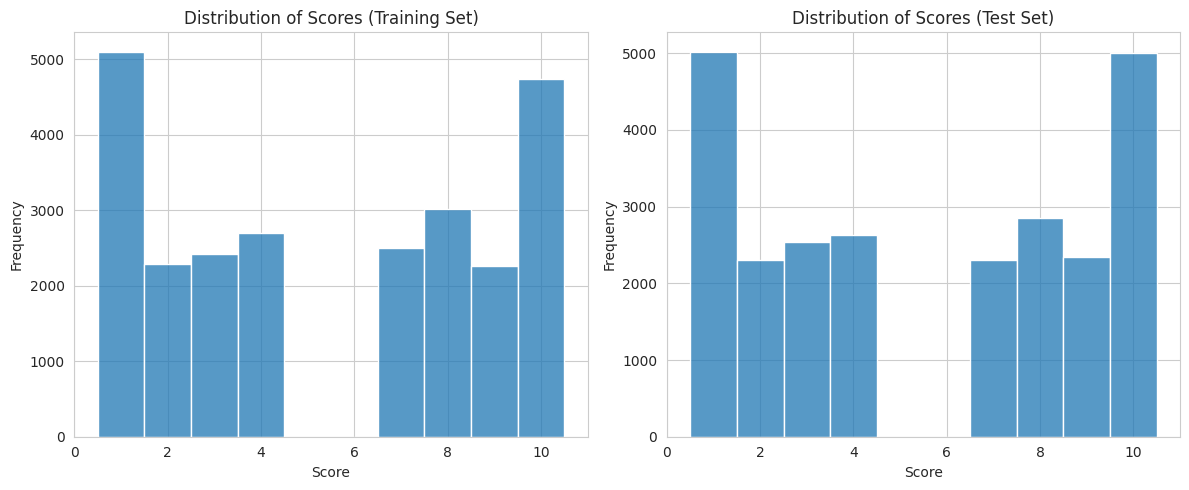

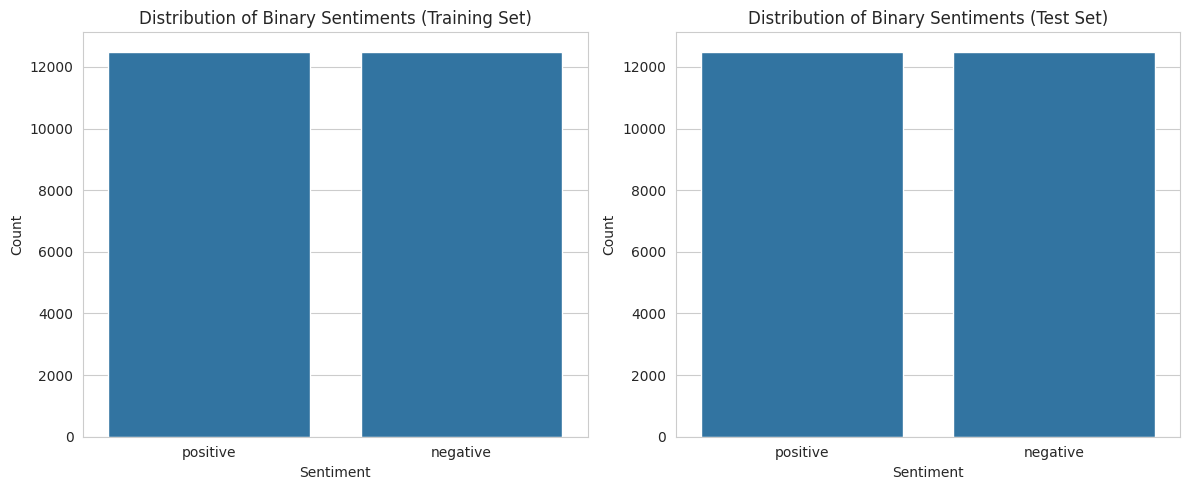

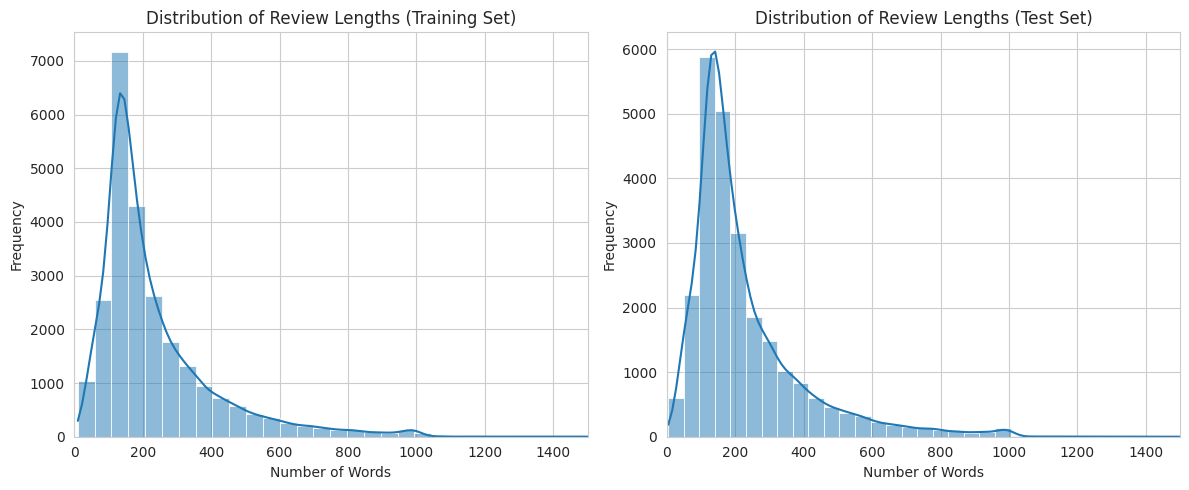

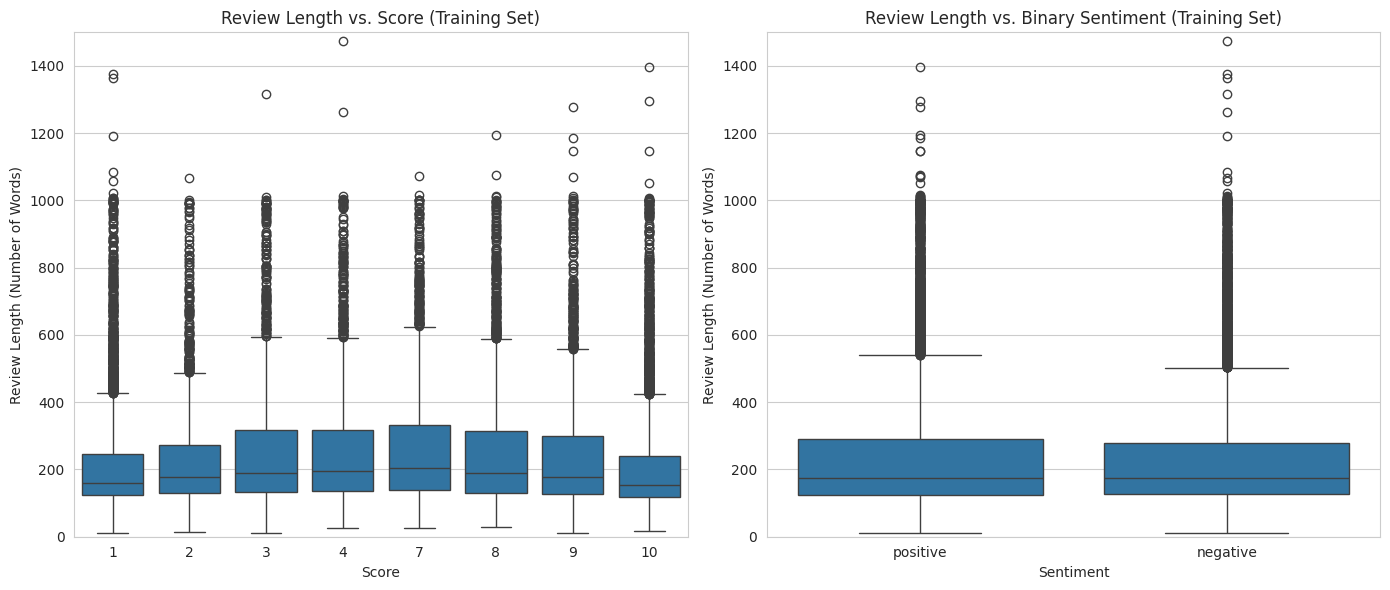

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # Ensure numpy is imported for np.nan

# Set style for plots
sns.set_style("whitegrid")

# 1. Distribution of Scores
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(train_df['score'], bins=10, kde=False, discrete=True)
plt.title('Distribution of Scores (Training Set)')
plt.xlabel('Score')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(test_df['score'], bins=10, kde=False, discrete=True)
plt.title('Distribution of Scores (Test Set)')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# 2. Distribution of Sentiments (Positive/Negative)
# Define binary sentiment based on scores
def assign_binary_sentiment(score):
    if score >= 7:
        return 'positive'
    elif score <= 4:
        return 'negative'
    else:
        return np.nan # For scores 5 and 6, which are often excluded

train_df_eda = train_df.copy() # Create a copy for EDA modifications
test_df_eda = test_df.copy()

train_df_eda['binary_sentiment'] = train_df_eda['score'].apply(assign_binary_sentiment)
test_df_eda['binary_sentiment'] = test_df_eda['score'].apply(assign_binary_sentiment)

# Drop rows where binary_sentiment is NaN (scores 5 or 6)
train_df_eda.dropna(subset=['binary_sentiment'], inplace=True)
test_df_eda.dropna(subset=['binary_sentiment'], inplace=True)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='binary_sentiment', data=train_df_eda, order=['positive', 'negative'])
plt.title('Distribution of Binary Sentiments (Training Set)')
plt.xlabel('Sentiment')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.countplot(x='binary_sentiment', data=test_df_eda, order=['positive', 'negative'])
plt.title('Distribution of Binary Sentiments (Test Set)')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# 3. Distribution of Review Lengths (Number of Words)
train_df_eda['review_length'] = train_df_eda['text'].apply(lambda x: len(x.split()))
test_df_eda['review_length'] = test_df_eda['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(train_df_eda['review_length'], bins=50, kde=True)
plt.title('Distribution of Review Lengths (Training Set)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.xlim(0, 1500) # Limiting x-axis for better visualization

plt.subplot(1, 2, 2)
sns.histplot(test_df_eda['review_length'], bins=50, kde=True)
plt.title('Distribution of Review Lengths (Test Set)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.xlim(0, 1500) # Limiting x-axis for better visualization
plt.tight_layout()
plt.show()

# 4. Review Lengths by Score/Sentiment (Training Set)
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='score', y='review_length', data=train_df_eda.sort_values('score'))
plt.title('Review Length vs. Score (Training Set)')
plt.xlabel('Score')
plt.ylabel('Review Length (Number of Words)')
plt.ylim(0, 1500) # Limiting y-axis for better visualization

plt.subplot(1, 2, 2)
sns.boxplot(x='binary_sentiment', y='review_length', data=train_df_eda, order=['positive', 'negative'])
plt.title('Review Length vs. Binary Sentiment (Training Set)')
plt.xlabel('Sentiment')
plt.ylabel('Review Length (Number of Words)')
plt.ylim(0, 1500) # Limiting y-axis for better visualization
plt.tight_layout()
plt.show()

## Clean HTML and tokenize text
Clean the review, handle the special characters, remove the html tags and tokenize the text based on the instructions given in the exercise sheet. 

In [17]:
import re

def remove_html_tags(text):
    """Remove html tags from a string"""
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text).strip()

In [20]:
import string
def tokenize_text(text):
    """
    Tokenize the input text by splitting on spaces and punctuation.
    Returns a list of tokens.
    """
    if not isinstance(text, str):
        raise TypeError("Input must be a string.")
    if not text:
        return []
    # Split on any whitespace or punctuation character
    tokens = re.split(r'[\s{}]+'.format(re.escape(string.punctuation)), text)
    # Remove empty tokens
    tokens = [token for token in tokens if token]
    return tokens


In [21]:

# Example usage with a sample cleaned text:
sample_cleaned_text = "this is a sample sentence with some words"
tokens = tokenize_text(sample_cleaned_text)
print(f"Original text: '{sample_cleaned_text}'")
print(f"Tokens: {tokens}")

# Example with text that might have extra spaces after cleaning
sample_cleaned_text_extra_spaces = "this   is   another  example "
tokens_extra_spaces = tokenize_text(sample_cleaned_text_extra_spaces)
print(f"Original text with extra spaces: '{sample_cleaned_text_extra_spaces}'")
print(f"Tokens: {tokens_extra_spaces}")

Original text: 'this is a sample sentence with some words'
Tokens: ['this', 'is', 'a', 'sample', 'sentence', 'with', 'some', 'words']
Original text with extra spaces: 'this   is   another  example '
Tokens: ['this', 'is', 'another', 'example']


In [22]:
import re

def remove_special_characters(text):
    """Remove special characters, keeping English letters (initially case-insensitive), numbers, and internal hyphens.
    Final output is lowercased and space-normalized."""
    # 1. Replace characters that are NOT English letters (any case), digits, hyphens, or whitespace with a space.
    text = re.sub(r'[^a-zA-Z0-9\s-]', ' ', text)
    
    # 2. Convert to lowercase for consistent processing.
    text = text.lower()
    
    # 3. Process hyphens:
    #    - Replace multiple consecutive hyphens with a single space.
    text = re.sub(r'-{2,}', ' ', text)
    
    #    - Tokenize by space, then clean hyphens for each token.
    words = []
    for word_candidate in text.split():
        # Remove hyphens from the start or end of the candidate.
        cleaned_word = word_candidate.strip('-')
        if cleaned_word:  # Only add non-empty words
            words.append(cleaned_word)
    text = ' '.join(words)
    
    # 4. Normalize multiple spaces to single spaces and strip leading/trailing whitespace.
    #    The ' '.join(words) handles much of this, but an explicit pass ensures cleanliness.
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

In [23]:
# Apply HTML tag removal and special character removal to the training and test DataFrames

# For training data
train_df['cleaned_text'] = train_df['text'].apply(remove_html_tags)

# For test data
test_df['cleaned_text'] = test_df['text'].apply(remove_html_tags)

# Verify the new column in train_df
print("\n--- Training DataFrame Info After Cleaning ---")
train_df.info()
print(train_df.head())

# Verify the new column in test_df
print("\n--- Test DataFrame Info After Cleaning ---")
test_df.info()
print(test_df.head())


--- Training DataFrame Info After Cleaning ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          25000 non-null  object
 1   score         25000 non-null  int64 
 2   sentiment     25000 non-null  object
 3   cleaned_text  25000 non-null  object
dtypes: int64(1), object(3)
memory usage: 781.4+ KB
                                                text  score sentiment  \
0  Prior to seeing Show People, my impression of ...      9  positive   
1  C'mon people, look at the title! LOL! I rememb...      7  positive   
2  FORBIDDEN PLANET is one of the best examples o...     10  positive   
3  "Shore Leave" is mostly an average Star Trek a...      7  positive   
4  I guess every time I see one of these old movi...      8  positive   

                                        cleaned_text  
0  Prior to seeing Show People, my impression 

In [24]:
# Apply the tokenize_text function to the 'processed_text' column.
# This function splits the text by spaces.
train_df['tokens'] = train_df['cleaned_text'].apply(tokenize_text)
test_df['tokens'] = test_df['cleaned_text'].apply(tokenize_text)

# Display the head of the DataFrames with the new columns to verify
print("--- Training DataFrame with 'cleaned_text' and 'tokens' columns ---")
print(train_df[['cleaned_text', 'tokens']].head())

print("\n--- Test DataFrame with 'cleaned_text' and 'tokens' columns ---")
print(test_df[['cleaned_text', 'tokens']].head())

--- Training DataFrame with 'cleaned_text' and 'tokens' columns ---
                                        cleaned_text  \
0  Prior to seeing Show People, my impression of ...   
1  C'mon people, look at the title! LOL! I rememb...   
2  FORBIDDEN PLANET is one of the best examples o...   
3  "Shore Leave" is mostly an average Star Trek a...   
4  I guess every time I see one of these old movi...   

                                              tokens  
0  [Prior, to, seeing, Show, People, my, impressi...  
1  [C, mon, people, look, at, the, title, LOL, I,...  
2  [FORBIDDEN, PLANET, is, one, of, the, best, ex...  
3  [Shore, Leave, is, mostly, an, average, Star, ...  
4  [I, guess, every, time, I, see, one, of, these...  

--- Test DataFrame with 'cleaned_text' and 'tokens' columns ---
                                        cleaned_text  \
0  I'm not sure what I can add that hasn't alread...   
1  In America, the Jewish Jonathan Safran Foer (E...   
2  I actually first watched One 

## Convert to lower case and remove punctuation

In [25]:
def normalize_and_remove_punctuation(text):
    """
    Normalize spaces, remove punctuation, and convert to lowercase.
    """
    # 1. Normalize spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    # 2. Remove punctuation (except hyphens)
    text = re.sub(r'[^\w\s-]', '', text)
    
    # 3. Convert to lowercase
    text = text.lower()
    
    return text

# Remove punctuation from tokens in train and test DataFrames
def remove_punctuation_from_tokens(tokens):
    return [normalize_and_remove_punctuation(token) for token in tokens]

train_df['tokens_no_punct'] = train_df['tokens'].apply(remove_punctuation_from_tokens)
test_df['tokens_no_punct'] = test_df['tokens'].apply(remove_punctuation_from_tokens)

# Display a few examples to verify
print(train_df[['tokens', 'tokens_no_punct']].head())
print(test_df[['tokens', 'tokens_no_punct']].head())

                                              tokens  \
0  [Prior, to, seeing, Show, People, my, impressi...   
1  [C, mon, people, look, at, the, title, LOL, I,...   
2  [FORBIDDEN, PLANET, is, one, of, the, best, ex...   
3  [Shore, Leave, is, mostly, an, average, Star, ...   
4  [I, guess, every, time, I, see, one, of, these...   

                                     tokens_no_punct  
0  [prior, to, seeing, show, people, my, impressi...  
1  [c, mon, people, look, at, the, title, lol, i,...  
2  [forbidden, planet, is, one, of, the, best, ex...  
3  [shore, leave, is, mostly, an, average, star, ...  
4  [i, guess, every, time, i, see, one, of, these...  
                                              tokens  \
0  [I, m, not, sure, what, I, can, add, that, has...   
1  [In, America, the, Jewish, Jonathan, Safran, F...   
2  [I, actually, first, watched, One, Dark, Night...   
3  [These, critics, need, to, find, a, new, job, ...   
4  [While, researching, Susan, Harrison, The, Bal... 

## Remove X percentage and build vocabulary 
Remove all the tokens that do not meet the requirements based on the exercise sheet and build the vocabulary. 

In [26]:
from collections import Counter

def calculate_frequent_terms_and_vocab(token_list_series, max_freq_percentage):

    # Flatten all token lists into a single list
    all_tokens = [token for sublist in token_list_series for token in sublist]
    
    if not all_tokens:
        print("Warning: No tokens found in the input series for vocabulary building.")
        return set(), []

    # Calculate frequency of each token
    term_counts = Counter(all_tokens)
    total_token_occurrences = len(all_tokens)
    
    threshold_count = (max_freq_percentage / 100.0) * total_token_occurrences
    
    overly_frequent_set = {
        token for token, count in term_counts.items() if count > threshold_count
    }
    
    print(f"Total unique tokens in the source for vocab construction: {len(term_counts)}")
    print(f"Identified {len(overly_frequent_set)} overly frequent tokens (frequency > {max_freq_percentage}% of total {total_token_occurrences} tokens).")
    if 0 < len(overly_frequent_set) < 20: # Print some examples if the list is short
        print(f"Examples of overly frequent tokens: {list(overly_frequent_set)[:10]}")
    
    # Build vocabulary from unique tokens, excluding the overly frequent ones
    unique_tokens_in_source = set(term_counts.keys())
    vocabulary_set = unique_tokens_in_source - overly_frequent_set
    vocabulary = sorted(list(vocabulary_set)) # Sort for consistent order
    print(f"Vocabulary size after removing frequent terms: {len(vocabulary)}")
    
    return overly_frequent_set, vocabulary

def filter_tokens_from_series(token_list_series, tokens_to_remove_set):
    def filter_document_tokens(doc_tokens_list):
        return [token for token in doc_tokens_list if token not in tokens_to_remove_set]
    return token_list_series.apply(filter_document_tokens)


In [27]:

# --- Define the percentage for frequency filtering ---
# You can change this value to experiment (e.g., 1.0, 5.0, 10.0)
MAX_CORPUS_FREQ_PERCENT = 10.0  # Example: Remove terms making up more than 10% of all token occurrences.

print(f"--- Building Vocabulary and Filtering Training Data (max_freq_percent = {MAX_CORPUS_FREQ_PERCENT}%) ---")
# Identify frequent terms and build vocabulary based on the 'tokens_no_punct' column of the training data.
# This column was created in CELL INDEX 21.
train_overly_frequent_terms, train_vocabulary_after_freq_filter = calculate_frequent_terms_and_vocab(
    train_df['tokens_no_punct'], 
    MAX_CORPUS_FREQ_PERCENT
)

# Create a new column in train_df with tokens filtered based on frequency.
# The name of the new column will reflect the percentage used.
train_filtered_tokens_col_name = f'tokens_no_punct_freq_filtered_{MAX_CORPUS_FREQ_PERCENT}pct'
train_df[train_filtered_tokens_col_name] = filter_tokens_from_series(
    train_df['tokens_no_punct'], 
    train_overly_frequent_terms
)
print(f"\nAdded '{train_filtered_tokens_col_name}' column to train_df.")
print("Head of train_df showing original and frequency-filtered tokens:")
print(train_df[[train_filtered_tokens_col_name, 'tokens_no_punct']].head())


print(f"\n--- Filtering Test Data (using frequent terms identified from training data, max_freq_percent = {MAX_CORPUS_FREQ_PERCENT}%) ---")
# Filter tokens in test_df using the set of 'train_overly_frequent_terms'.
# It's crucial to use the frequent terms identified from the training set to avoid data leakage.
test_filtered_tokens_col_name = f'tokens_no_punct_freq_filtered_{MAX_CORPUS_FREQ_PERCENT}pct'
test_df[test_filtered_tokens_col_name] = filter_tokens_from_series(
    test_df['tokens_no_punct'], 
    train_overly_frequent_terms 
)
print(f"\nAdded '{test_filtered_tokens_col_name}' column to test_df.")
print("Head of test_df showing original and frequency-filtered tokens:")
print(test_df[[test_filtered_tokens_col_name, 'tokens_no_punct']].head())

# The `train_vocabulary_after_freq_filter` is the vocabulary to be used for subsequent steps 
# (e.g., stemming, BOW construction) if no further vocabulary refinement is done before that.
print(f"\nVocabulary based on training data (after removing terms with >{MAX_CORPUS_FREQ_PERCENT}% corpus frequency) contains {len(train_vocabulary_after_freq_filter)} words.")
if len(train_vocabulary_after_freq_filter) > 0 and len(train_vocabulary_after_freq_filter) < 20:
    print(f"First 10 vocabulary examples: {train_vocabulary_after_freq_filter[:10]}")


--- Building Vocabulary and Filtering Training Data (max_freq_percent = 10.0%) ---
Total unique tokens in the source for vocab construction: 76063
Identified 0 overly frequent tokens (frequency > 10.0% of total 5954631 tokens).
Vocabulary size after removing frequent terms: 76063

Added 'tokens_no_punct_freq_filtered_10.0pct' column to train_df.
Head of train_df showing original and frequency-filtered tokens:
               tokens_no_punct_freq_filtered_10.0pct  \
0  [prior, to, seeing, show, people, my, impressi...   
1  [c, mon, people, look, at, the, title, lol, i,...   
2  [forbidden, planet, is, one, of, the, best, ex...   
3  [shore, leave, is, mostly, an, average, star, ...   
4  [i, guess, every, time, i, see, one, of, these...   

                                     tokens_no_punct  
0  [prior, to, seeing, show, people, my, impressi...  
1  [c, mon, people, look, at, the, title, lol, i,...  
2  [forbidden, planet, is, one, of, the, best, ex...  
3  [shore, leave, is, mostly, 

## Use Porter Stemmer for stemming

In [30]:
# Apply Porter stemming to the frequency-filtered tokens in train and test DataFrames

def stem_tokens(tokens, stemmer):
    return [stemmer.stem(token) for token in tokens]

# Use the same column names as in previous steps
train_stemmed_col = f'{train_filtered_tokens_col_name}_stemmed'
test_stemmed_col = f'{test_filtered_tokens_col_name}_stemmed'

train_df[train_stemmed_col] = train_df[train_filtered_tokens_col_name].apply(lambda tokens: stem_tokens(tokens, stemmer))
test_df[test_stemmed_col] = test_df[test_filtered_tokens_col_name].apply(lambda tokens: stem_tokens(tokens, stemmer))

print(f"Added '{train_stemmed_col}' to train_df and '{test_stemmed_col}' to test_df.")
print(train_df[[train_filtered_tokens_col_name, train_stemmed_col]].head())
print(test_df[[test_filtered_tokens_col_name, test_stemmed_col]].head())

Added 'tokens_no_punct_freq_filtered_10.0pct_stemmed' to train_df and 'tokens_no_punct_freq_filtered_10.0pct_stemmed' to test_df.
               tokens_no_punct_freq_filtered_10.0pct  \
0  [prior, to, seeing, show, people, my, impressi...   
1  [c, mon, people, look, at, the, title, lol, i,...   
2  [forbidden, planet, is, one, of, the, best, ex...   
3  [shore, leave, is, mostly, an, average, star, ...   
4  [i, guess, every, time, i, see, one, of, these...   

       tokens_no_punct_freq_filtered_10.0pct_stemmed  
0  [prior, to, see, show, peopl, my, impress, of,...  
1  [c, mon, peopl, look, at, the, titl, lol, i, r...  
2  [forbidden, planet, is, one, of, the, best, ex...  
3  [shore, leav, is, mostli, an, averag, star, tr...  
4  [i, guess, everi, time, i, see, one, of, these...  
               tokens_no_punct_freq_filtered_10.0pct  \
0  [i, m, not, sure, what, i, can, add, that, has...   
1  [in, america, the, jewish, jonathan, safran, f...   
2  [i, actually, first, watched, on

## Build the bag of words (BOW)
For building the matrix for the representation of bag of words use the previously built vocabulary and tokens for each review.

In [31]:
from collections import Counter
import numpy as np
from scipy.sparse import lil_matrix # Import lil_matrix for efficient construction

# 1. Create the vocabulary from the stemmed tokens in the training data
# train_stemmed_col is like 'tokens_no_punct_freq_filtered_1.0pct_stemmed'
all_stemmed_tokens_train = [token for sublist in train_df[train_stemmed_col] for token in sublist]
custom_bow_vocabulary = sorted(list(set(all_stemmed_tokens_train)))

# 2. Create a word-to-index mapping
word_to_idx = {word: i for i, word in enumerate(custom_bow_vocabulary)}
vocab_size = len(custom_bow_vocabulary)

print(f"Custom BOW vocabulary size (from stemmed training tokens): {vocab_size}")
if vocab_size < 20: # Print some examples if vocab is small
    print(f"Vocabulary examples: {custom_bow_vocabulary[:10]}")

Custom BOW vocabulary size (from stemmed training tokens): 52455


In [33]:

# 3. Function to build the BOW matrix
def build_bow_matrix(docs_token_series, word_to_idx_map, vocabulary_size):
    
    num_documents = len(docs_token_series)
    # Use lil_matrix for efficient incremental construction
    bow_matrix = lil_matrix((num_documents, vocabulary_size), dtype=int)
    
    for i, doc_tokens in enumerate(docs_token_series):
        doc_token_counts = Counter(doc_tokens)
        for token, count in doc_token_counts.items():
            if token in word_to_idx_map:
                bow_matrix[i, word_to_idx_map[token]] = count
    # Convert to csr_matrix for efficient row slicing and matrix operations
    return bow_matrix.tocsr()


In [34]:

# 4. Build BOW for training data
X_train_bow_custom = build_bow_matrix(train_df[train_stemmed_col], word_to_idx, vocab_size)

# 5. Build BOW for test data (using the vocabulary from training data)
X_test_bow_custom = build_bow_matrix(test_df[test_stemmed_col], word_to_idx, vocab_size)

print(f"\nShape of custom BOW matrix for training data: {X_train_bow_custom.shape}")
print(f"Shape of custom BOW matrix for test data: {X_test_bow_custom.shape}")


# Verify that scores are still aligned (binary sentiment for classification)
# Positive: score >= 7 (map to 1)
# Negative: score <= 4 (map to 0)
# We need to filter out scores 5 and 6 as per typical sentiment analysis tasks
y_train_custom = train_df['score'].apply(lambda x: 1 if x >= 7 else (0 if x <= 4 else -1))
y_test_custom = test_df['score'].apply(lambda x: 1 if x >= 7 else (0 if x <= 4 else -1))

# Create boolean NumPy arrays for filtering
train_filter_mask = (y_train_custom != -1).to_numpy()
test_filter_mask = (y_test_custom != -1).to_numpy()

# Filter out rows with sentiment -1 (scores 5 or 6) using NumPy boolean masks
X_train_bow_custom = X_train_bow_custom[train_filter_mask]
y_train_custom = y_train_custom[train_filter_mask].to_numpy() # Filter Series then convert to NumPy array

X_test_bow_custom = X_test_bow_custom[test_filter_mask]
y_test_custom = y_test_custom[test_filter_mask].to_numpy() # Filter Series then convert to NumPy array

print(f"\nShape of X_train_bow_custom after filtering neutral reviews: {X_train_bow_custom.shape}")
print(f"Shape of y_train_custom after filtering neutral reviews: {y_train_custom.shape}")
print(f"Shape of X_test_bow_custom after filtering neutral reviews: {X_test_bow_custom.shape}")
print(f"Shape of y_test_custom after filtering neutral reviews: {y_test_custom.shape}")
print(f"Unique values in y_train_custom: {np.unique(y_train_custom, return_counts=True)}")
print(f"Unique values in y_test_custom: {np.unique(y_test_custom, return_counts=True)}")


Shape of custom BOW matrix for training data: (25000, 52455)
Shape of custom BOW matrix for test data: (25000, 52455)

Shape of X_train_bow_custom after filtering neutral reviews: (25000, 52455)
Shape of y_train_custom after filtering neutral reviews: (25000,)
Shape of X_test_bow_custom after filtering neutral reviews: (25000, 52455)
Shape of y_test_custom after filtering neutral reviews: (25000,)
Unique values in y_train_custom: (array([0, 1]), array([12500, 12500]))
Unique values in y_test_custom: (array([0, 1]), array([12500, 12500]))


# Task 3: Comparing BOWs

1. Use the previous steps to build a bag of words with the training data in which the tokens that appear more than 1% are discarded. 
1. Compare your BOW with LIBSVM BOW. 

In [36]:
# Ensure X and y from LIBSVM are filtered for binary sentiment like X_train_bow_custom and y_train_custom
# y was loaded as a float array from load_svmlight_file
y_libsvm_binary = np.array([1 if score >= 7 else (0 if score <= 4 else -1) for score in y])

# Create a filter mask for LIBSVM data
libsvm_filter_mask = (y_libsvm_binary != -1)

# Apply the filter to X (LIBSVM BOW features) and y_libsvm_binary
X_libsvm_filtered = X[libsvm_filter_mask]
y_libsvm_filtered = y_libsvm_binary[libsvm_filter_mask]

print("--- Comparison of Custom BOW and LIBSVM BOW (Training Data) ---")

# 1. Shapes of the BOW matrices
print("\n1. Shapes of BOW Matrices:")
print(f"   Custom BOW (X_train_bow_custom) shape: {X_train_bow_custom.shape}")
print(f"   LIBSVM BOW (X_libsvm_filtered) shape:  {X_libsvm_filtered.shape}")
# Note: y_train_custom and y_libsvm_filtered should have the same length as the number of rows in their respective X matrices.
print(f"   Custom BOW labels (y_train_custom) shape: {y_train_custom.shape}")
print(f"   LIBSVM BOW labels (y_libsvm_filtered) shape:  {y_libsvm_filtered.shape}")


# 2. Vocabulary Sizes
# The vocabulary for custom BOW is `custom_bow_vocabulary` (derived from stemmed, freq-filtered tokens)
# The vocabulary for LIBSVM BOW is `vocabulary` (from imdb.vocab)
print("\n2. Vocabulary Sizes:")
print(f"   Custom BOW vocabulary size: {len(custom_bow_vocabulary)}")
print(f"   LIBSVM BOW vocabulary size: {len(vocabulary)}") # This is the original vocabulary from imdb.vocab

# 3. Number of Non-Zero Elements (Sparsity)
print("\n3. Number of Non-Zero Elements (Sparsity):")
print(f"   Custom BOW non-zero elements: {X_train_bow_custom.nnz}")
print(f"   LIBSVM BOW non-zero elements:  {X_libsvm_filtered.nnz}")
if X_train_bow_custom.shape[0] > 0:
    custom_sparsity = 1.0 - (X_train_bow_custom.nnz / (X_train_bow_custom.shape[0] * X_train_bow_custom.shape[1]))
    print(f"   Custom BOW sparsity: {custom_sparsity:.4f}")
if X_libsvm_filtered.shape[0] > 0:
    libsvm_sparsity = 1.0 - (X_libsvm_filtered.nnz / (X_libsvm_filtered.shape[0] * X_libsvm_filtered.shape[1]))
    print(f"   LIBSVM BOW sparsity: {libsvm_sparsity:.4f}")

# 4. Vocabulary Comparison (Common and Unique Words)
# `custom_bow_vocabulary` is already a list of unique, sorted, stemmed words
# `vocabulary` is the list of words from imdb.vocab
set_custom_vocab = set(custom_bow_vocabulary)
set_libsvm_vocab = set(vocabulary)

common_words = set_custom_vocab.intersection(set_libsvm_vocab)
unique_to_custom = set_custom_vocab.difference(set_libsvm_vocab)
unique_to_libsvm = set_libsvm_vocab.difference(set_custom_vocab)

print("\n4. Vocabulary Content Comparison:")
print(f"   Number of common words: {len(common_words)}")
print(f"   Number of words unique to Custom BOW: {len(unique_to_custom)}")
print(f"   Number of words unique to LIBSVM BOW: {len(unique_to_libsvm)}")

if len(common_words) > 0 and len(common_words) < 10:
    print(f"   Examples of common words: {list(common_words)[:5]}")
if len(unique_to_custom) > 0 and len(unique_to_custom) < 10:
     print(f"   Examples of words unique to Custom BOW: {list(unique_to_custom)[:5]}")
if len(unique_to_libsvm) > 0 and len(unique_to_libsvm) < 10:
    print(f"   Examples of words unique to LIBSVM BOW: {list(unique_to_libsvm)[:5]}")

--- Comparison of Custom BOW and LIBSVM BOW (Training Data) ---

1. Shapes of BOW Matrices:
   Custom BOW (X_train_bow_custom) shape: (25000, 52455)
   LIBSVM BOW (X_libsvm_filtered) shape:  (25000, 89527)
   Custom BOW labels (y_train_custom) shape: (25000,)
   LIBSVM BOW labels (y_libsvm_filtered) shape:  (25000,)

2. Vocabulary Sizes:
   Custom BOW vocabulary size: 52455
   LIBSVM BOW vocabulary size: 89527

3. Number of Non-Zero Elements (Sparsity):
   Custom BOW non-zero elements: 3424037
   LIBSVM BOW non-zero elements:  3456685
   Custom BOW sparsity: 0.9974
   LIBSVM BOW sparsity: 0.9985

4. Vocabulary Content Comparison:
   Number of common words: 31710
   Number of words unique to Custom BOW: 20745
   Number of words unique to LIBSVM BOW: 57817


# Task 4: Train a Random Forest and test it


In [37]:
def train_and_evaluate_rf(X_train, y_train, X_test, y_test, bow_name="Custom"):
    """
    Trains a Random Forest classifier and evaluates it.
    
    Parameters:
    X_train: Training features
    y_train: Training labels
    X_test: Test features
    y_test: Test labels
    bow_name: Name of the BOW representation for printing results
    
    Returns:
    accuracy: Accuracy score on the test set
    f1: F1 score on the test set
    """
    print(f"\n--- Training Random Forest on {bow_name} BOW ---")
    # Initialize Random Forest Classifier
    # You can tune parameters like n_estimators, max_depth, etc.
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1) # Using n_jobs=-1 for parallel processing
    
    print("Starting training...")
    rf_classifier.fit(X_train, y_train)
    print("Training complete.")
    
    print("Starting prediction on test set...")
    y_pred = rf_classifier.predict(X_test)
    print("Prediction complete.")
    
    accuracy = accuracy_score(y_test, y_pred)
    # Calculate F1 score (binary classification, positive label is 1)
    f1 = f1_score(y_test, y_pred, pos_label=1) 
    print(f"Accuracy of Random Forest on {bow_name} BOW test set: {accuracy:.4f}")
    print(f"F1-Score of Random Forest on {bow_name} BOW test set: {f1:.4f}")
    return accuracy, f1


In [38]:

# 1. Train and test on Custom BOW
# X_train_bow_custom, y_train_custom, X_test_bow_custom, y_test_custom are already prepared
accuracy_custom_bow, f1_custom_bow = train_and_evaluate_rf(X_train_bow_custom, y_train_custom, 
                                            X_test_bow_custom, y_test_custom, 
                                            bow_name="Custom Processed")

# 2. Prepare LIBSVM test data (filter for binary sentiment)
# X_test and y_test are from the initial load_svmlight_file for the 'test' partition
y_libsvm_test_binary = np.array([1 if score >= 7 else (0 if score <= 4 else -1) for score in y_test])
libsvm_test_filter_mask = (y_libsvm_test_binary != -1)

X_libsvm_test_filtered = X_test[libsvm_test_filter_mask]
y_libsvm_test_filtered = y_libsvm_test_binary[libsvm_test_filter_mask]

# Ensure the LIBSVM training data (X_libsvm_filtered, y_libsvm_filtered) is available from Task 3
# If not, you might need to re-run or ensure those variables are in the kernel's memory.
# For this example, we assume X_libsvm_filtered and y_libsvm_filtered from Task 3 are the training sets.

accuracy_libsvm_bow, f1_libsvm_bow = train_and_evaluate_rf(X_libsvm_filtered, y_libsvm_filtered, 
                                            X_libsvm_test_filtered, y_libsvm_test_filtered, 
                                            bow_name="LIBSVM Pre-provided")

print("\n--- Summary of Random Forest Metrics ---")
print(f"Custom Processed BOW - Accuracy: {accuracy_custom_bow:.4f}, F1-Score: {f1_custom_bow:.4f}")
print(f"LIBSVM Pre-provided BOW - Accuracy: {accuracy_libsvm_bow:.4f}, F1-Score: {f1_libsvm_bow:.4f}")


--- Training Random Forest on Custom Processed BOW ---
Starting training...
Training complete.
Starting prediction on test set...
Prediction complete.
Accuracy of Random Forest on Custom Processed BOW test set: 0.8429
F1-Score of Random Forest on Custom Processed BOW test set: 0.8426

--- Training Random Forest on LIBSVM Pre-provided BOW ---
Starting training...
Training complete.
Starting prediction on test set...
Prediction complete.
Accuracy of Random Forest on LIBSVM Pre-provided BOW test set: 0.8452
F1-Score of Random Forest on LIBSVM Pre-provided BOW test set: 0.8444

--- Summary of Random Forest Metrics ---
Custom Processed BOW - Accuracy: 0.8429, F1-Score: 0.8426
LIBSVM Pre-provided BOW - Accuracy: 0.8452, F1-Score: 0.8444


# Task 5: Markov chain
Tip: For memory optimization use sparse structures not a matrix mostrly filled with zeros

In [50]:
tokenized_reviews = train_df['tokens'].tolist()

## Pre-process data
Read the data and using the previous built functions for the BOW representation create a list of words per each review

## Chain words
Identify all the possible pairs of words (w0, w1) in all the reviews

In [51]:
bigrams = []
for tokens in tokenized_reviews:
    # Create bigrams from the list of tokens
    bigrams.extend([(tokens[i], tokens[i + 1]) for i in range(len(tokens) - 1)])


## Initialize the Markov's Chain

In [52]:
from collections import defaultdict

markov_chain = defaultdict(Counter)
for first, second in bigrams:
    markov_chain[first][second] += 1
    
markov_probs = {}
for w0, counter in markov_chain.items():
    total_count = sum(counter.values())
    markov_probs[w0] = {w1: count / total_count for w1, count in counter.items()}

## Generate data

Here you could also try to generate words for the unlabeled part of the dataset. Try to meassure the quality of the model

In [45]:
def generate_sentence(start_word, length=10, markov_probs=markov_probs):
    """Generate a sentence starting with a given word using the Markov chain probabilities."""
    if start_word not in markov_probs:
        return "Start word not found in the Markov chain."
    
    current_word = start_word
    sentence = [current_word]
    
    for _ in range(length - 1):
        next_words = list(markov_probs.get(current_word, {}).keys())
        if not next_words:
            break  # No next words available, stop generation
        current_word = np.random.choice(next_words, p=list(markov_probs[current_word].values()))
        sentence.append(current_word)
    
    return ' '.join(sentence)

In [54]:
sentence = generate_sentence(start_word='maybe', length=30, markov_probs=markov_probs)
print(f"Generated sentence starting with 'maybe': {sentence}")

Generated sentence starting with 'maybe': maybe more money from the talking into the movie that is the imbecile much more Dick Foran is particularly the film goer Turns on the people in Spawn of the
